# B W Photo Colorization
**Based on "Black and white image colorization with OpenCV and Deep Learning", by Dr. Adrian Rosebrok:**<br>
https://www.pyimagesearch.com/2019/02/25/black-and-white-image-colorization-with-opencv-and-deep-learning/

**Paper:**<br>
Colorful Image Colorization, Richard Zhang, Phillip Isola, Alexei A. Efros<br>
https://arxiv.org/pdf/1603.08511.pdf

## Image to be converted

In [18]:
IMAGE =  "darwin_in_rio_de_janeiro.jpg"

## Import important Libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Define Model Paths

In [21]:
ls ./model

colorization_deploy_v2.prototxt     pts_in_hull.npy
colorization_release_v2.caffemodel


In [22]:
prototxt = "./model/colorization_deploy_v2.prototxt"
model = "./model/colorization_release_v2.caffemodel"
points = "./model/pts_in_hull.npy"
image =  "./input_images/"+IMAGE

## Load serialized black and white colorizer model and cluster

In [23]:
# center points from disk
net = cv2.dnn.readNetFromCaffe(prototxt, model)
pts = np.load(points)

## Add the cluster centers as 1x1 convolutions to the model

In [24]:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

## Load the input image from disk and scale it and convert it to LAB

In [25]:
# scale the pixel intensities to the range [0, 1], and then convert the image from the BGR to Lab color space
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)

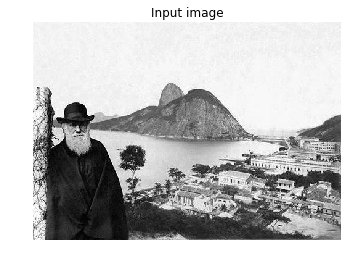

In [26]:
plt.imshow(image)
plt.axis('off');
plt.title('Input image');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


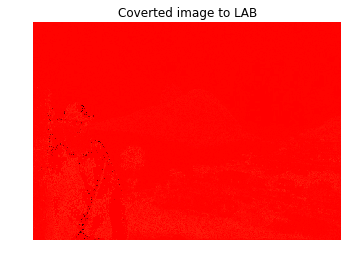

In [27]:
plt.imshow(lab)
plt.axis('off');
plt.title('Coverted image to LAB');

## Colorizing...

In [28]:
# resize the Lab image to 224x224 (the dimensions the colorization
# network accepts), split channels, extract the 'L' channel, and then
# perform mean centering
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

In [29]:
# pass the L channel through the network which will *predict* the 'a'
# and 'b' channel values
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

In [30]:
# resize the predicted 'ab' volume to the same dimensions as our
# input image
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

In [31]:
# grab the 'L' channel from the *original* input image (not the
# resized one) and concatenate the original 'L' channel with the
# predicted 'ab' channels
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


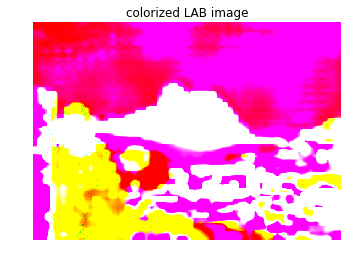

In [32]:
plt.imshow(colorized)
plt.axis('off');
plt.title('colorized LAB image');

In [33]:
# convert the output image from the Lab color space to RGB, then
# clip any values that fall outside the range [0, 1]
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
colorized = np.clip(colorized, 0, 1)

In [34]:
# the current colorized image is represented as a floating point
# data type in the range [0, 1] -- let's convert to an unsigned
# 8-bit integer representation in the range [0, 255]
colorized = (255 * colorized).astype("uint8")

## Display and save colorized image

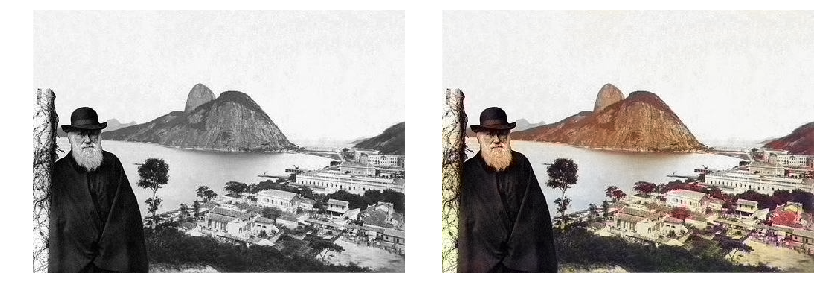

In [35]:
plt.figure(1, figsize=(14,6))
plt.subplots_adjust(wspace=0.1)
plt.subplot(121)
plt.axis('off');
plt.imshow(image);

plt.subplot(122)
plt.axis('off');
plt.imshow(colorized);

In [36]:
cv2.imwrite("./colorized_images/Color_"+IMAGE, cv2.cvtColor(colorized, cv2.COLOR_RGB2BGR))

True